# Pytorch with the MNIST Dataset - MINST

In [1]:
## import libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
print(torch.__version__)

2.5.0+cu121


In [3]:
args={}
kwargs={}
args['batch_size']=64
args['test_batch_size']=64
args['epochs']=4  #The number of Epochs is the number of times you go through the full dataset.
args['lr']=0.05 #Learning rate is how fast it will decend.
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=True #if the computer has a GPU, type True, otherwise, False

This code is adopted from the pytorch examples repository. It is licensed under BSD 3-Clause "New" or "Revised" License. Source: https://github.com/pytorch/examples/ LICENSE: https://github.com/pytorch/examples/blob/master/LICENSE

## Load Dataset
The first step before training the model is to import the data. We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) which is like the Hello World dataset of machine learning.

Besides importing the data, we will also do a few more things:
- We will tranform the data into tensors using the `transforms` module
- We will use `DataLoader` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models.
- As hinted above, we will also create batches of the data by setting the `batch` parameter inside the data loader. Notice we use batches of `32` in this tutorial but you can change it to `64` if you like. I encourage you to experiment with different batches.

In [4]:
## transformations
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

## download and load training dataset
trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args['batch_size'], shuffle=True, **kwargs)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args['test_batch_size'], shuffle=True, **kwargs)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.56MB/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.28MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Exploring the Data
As a practioner and researcher, I am always spending a bit of time and effort exploring and understanding the dataset. It's fun and this is a good practise to ensure that everything is in order.

Let's check what the train and test dataset contains. I will use `matplotlib` to print out some of the images from our dataset.

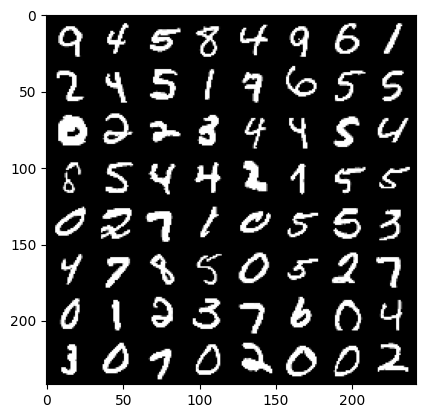

In [5]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images))

Let's check the dimensions of a batch.

In [6]:
for images, labels in train_loader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


## The Model
We provide two fully-connected neural net as the initial architecture.

Here are a few notes for those who are beginning with PyTorch:
- The model below consists of an `__init__()` portion which is where you include the layers and components of the neural network. In our model, we have two fully-connected netork network. We are dealing with an image dataset that is in a grayscale so we only need one channel going in, hence `in_channels=1`.

- After the first layer, we also apply an activation function such as `ReLU`. For prediction purposes, we then apply a `softmax` layer to the last transformation and return the output of that.  

In [19]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 25, 3) #1x28x28 --> 25x26x26
        self.pool = nn.MaxPool2d(2, 2) #25x26x26 --> 25x13x13
        self.conv2 = nn.Conv2d(25, 50, 3) #25x13x13 --> 50x11x11
        self.pool2 = nn.MaxPool2d(2, 2) #50x11x11 --> 50x5x5
        self.fc1 = nn.Linear(50 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = self.pool(x)
        x = torch.sigmoid(self.conv2(x))
        x = self.pool2(x)
        x=x.view(-1, 50 * 5 * 5)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        #Softmax gets probabilities.
        return F.log_softmax(x, dim=1)


**Now, add one CNN layer with a pooling to the above neural network and rerun the code to see whether you get higher prediction accuracy on the test set.**

For example, you may try `out_channels=32`. Kernel size is 5, and for the rest of parameters we use the default values which you can find [here](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#conv2d).

- In short, the convolutional layer transforms the input data into a specific dimension that has to be considered in the linear layer.

Make sure your flatten the output of CNN layer excluding # of batch so that the input of each example/batch has the same size of the first neural net.

Tips: You can use x.view(-1, # of input size of the first fully-connected layer) or you can use torch.flatten(x, 1).

I always encourage to test the model with 1 batch to ensure that the output dimensions are what we expect.

In [20]:
## test the model with 1 batch
model = Net()
#print(model)
for images, labels in train_loader:
    print("batch size:", args['batch_size'])
    out = model(images)
    print(out.shape)
    break

batch size: 64
torch.Size([64, 10])


## Training the Model
Now we are ready to train the model.

In [21]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable.
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch.
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically.
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [22]:
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if args['cuda']:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)
          output = model(data)
          test_loss += F.nll_loss(output, target, size_average=False).data.item() # sum up batch loss
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
          correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [23]:
model = Net()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.332230
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.352387
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.342764
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.338468
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.332134
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.359130
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.319621
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.290757
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.324882
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.352702
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.276189
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.386851
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.337225
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.343331
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.326425
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.293749
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.351182
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.300830
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.315797
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.313698
Train Epoch: 1 [12800/60000 (

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.7022, Accuracy: 8153/10000 (82%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.494192
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.764001
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.655934
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.667587
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.751194
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.650824
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.795617
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.591310
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.471134
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.598798
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.602898
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.570648
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.454899
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.595283
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.506879
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.526152
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.617483
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.751370
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.415236
Train Epoch: 2 [12